In [4]:
import sys #Needed some installs; took line below from https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
!conda install --yes --prefix {sys.prefix} datashader  
!conda install --yes --prefix {sys.prefix} pyproj
!conda install --yes --prefix {sys.prefix} plotly
#!conda install --yes --prefix {sys.prefix} colorlover

import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy

from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
#import colorlover as cl   #Not sure if this is actually used; was having trouble installing

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

# from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON
    
py.init_notebook_mode()

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

### Comment on data set

It seems the most recent PLUTO data set isn't broken down into different boros, and is well over the limit that can be uploaded to GitHub.  For simplicity, the data set will be read directly from the machine this is run on.  

In [6]:
#Update the path as nessicary to run on your machine
path = r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 608 Knowledge and Visual Analytics\Module 2\pluto_20v8.csv' 
ny = pd.read_csv(path)


# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]

I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [7]:


# wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
# nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
# ny['xcoord'] = 0.3048*ny['xcoord']
# ny['ycoord'] = 0.3048*ny['ycoord']
# ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['xcoord'].values, ny['ycoord'].values)

# ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [8]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.FigureWidget(data = [trace], layout = layout)

fig

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': 'eee9a528-6e9b-4f4c-b56e-6a021780a860',
 …

Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

104.0
0.1
2.0


(array([7.43640e+04, 4.51883e+05, 2.14892e+05, 2.90710e+04, 1.70550e+04,
        1.25100e+04, 2.46800e+03, 1.27000e+03, 7.66000e+02, 5.92000e+02,
        4.66000e+02, 9.59000e+02, 4.92000e+02, 4.49000e+02, 4.34000e+02,
        4.84000e+02, 2.36000e+02, 1.71000e+02, 2.15000e+02, 2.87000e+02,
        1.90000e+02, 1.14000e+02, 9.00000e+01, 8.60000e+01, 8.50000e+01,
        7.90000e+01, 6.40000e+01, 4.80000e+01, 3.90000e+01, 6.30000e+01,
        5.90000e+01, 6.70000e+01, 5.70000e+01, 4.70000e+01, 4.60000e+01,
        3.40000e+01, 2.70000e+01, 2.60000e+01, 3.60000e+01, 3.30000e+01,
        2.90000e+01, 3.90000e+01, 2.80000e+01, 2.10000e+01, 2.00000e+01,
        1.70000e+01, 1.10000e+01, 1.50000e+01, 9.00000e+00, 1.40000e+01,
        1.60000e+01, 1.00000e+01, 4.00000e+00, 1.20000e+01, 3.00000e+00,
        5.00000e+00, 8.00000e+00, 7.00000e+00, 3.00000e+00, 5.00000e+00,
        3.00000e+00, 3.00000e+00, 4.00000e+00, 3.00000e+00, 0.00000e+00,
        1.00000e+00, 2.00000e+00, 2.00000e+00, 1.00

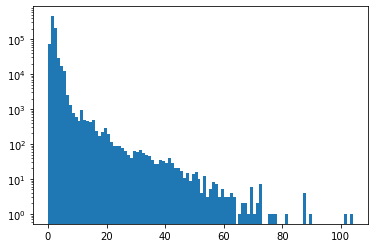

In [9]:
import matplotlib.pyplot as plt #Import a plotting package
#print(ny.keys())  #Find the variable I'm looking for.  Turned out to be numfloors
print(ny.numfloors.max())
print(ny.numfloors.min())
print(ny.numfloors.median())
plt.hist(ny.numfloors, bins = 104, log = True)

### Answer 

Above is a quick investigation into the 'numfloors' data.  First we found out that the median floor count was 2, which implies that our interest will be amongst for rare cases as those are the higher floor buildings.  Also, the maximum number of floors was 104, giving us an upper limit.  Interestingly, there are also buildings under 1 floor; I'm not sure why this is.

Let's throw together a figure and see what it looks like.

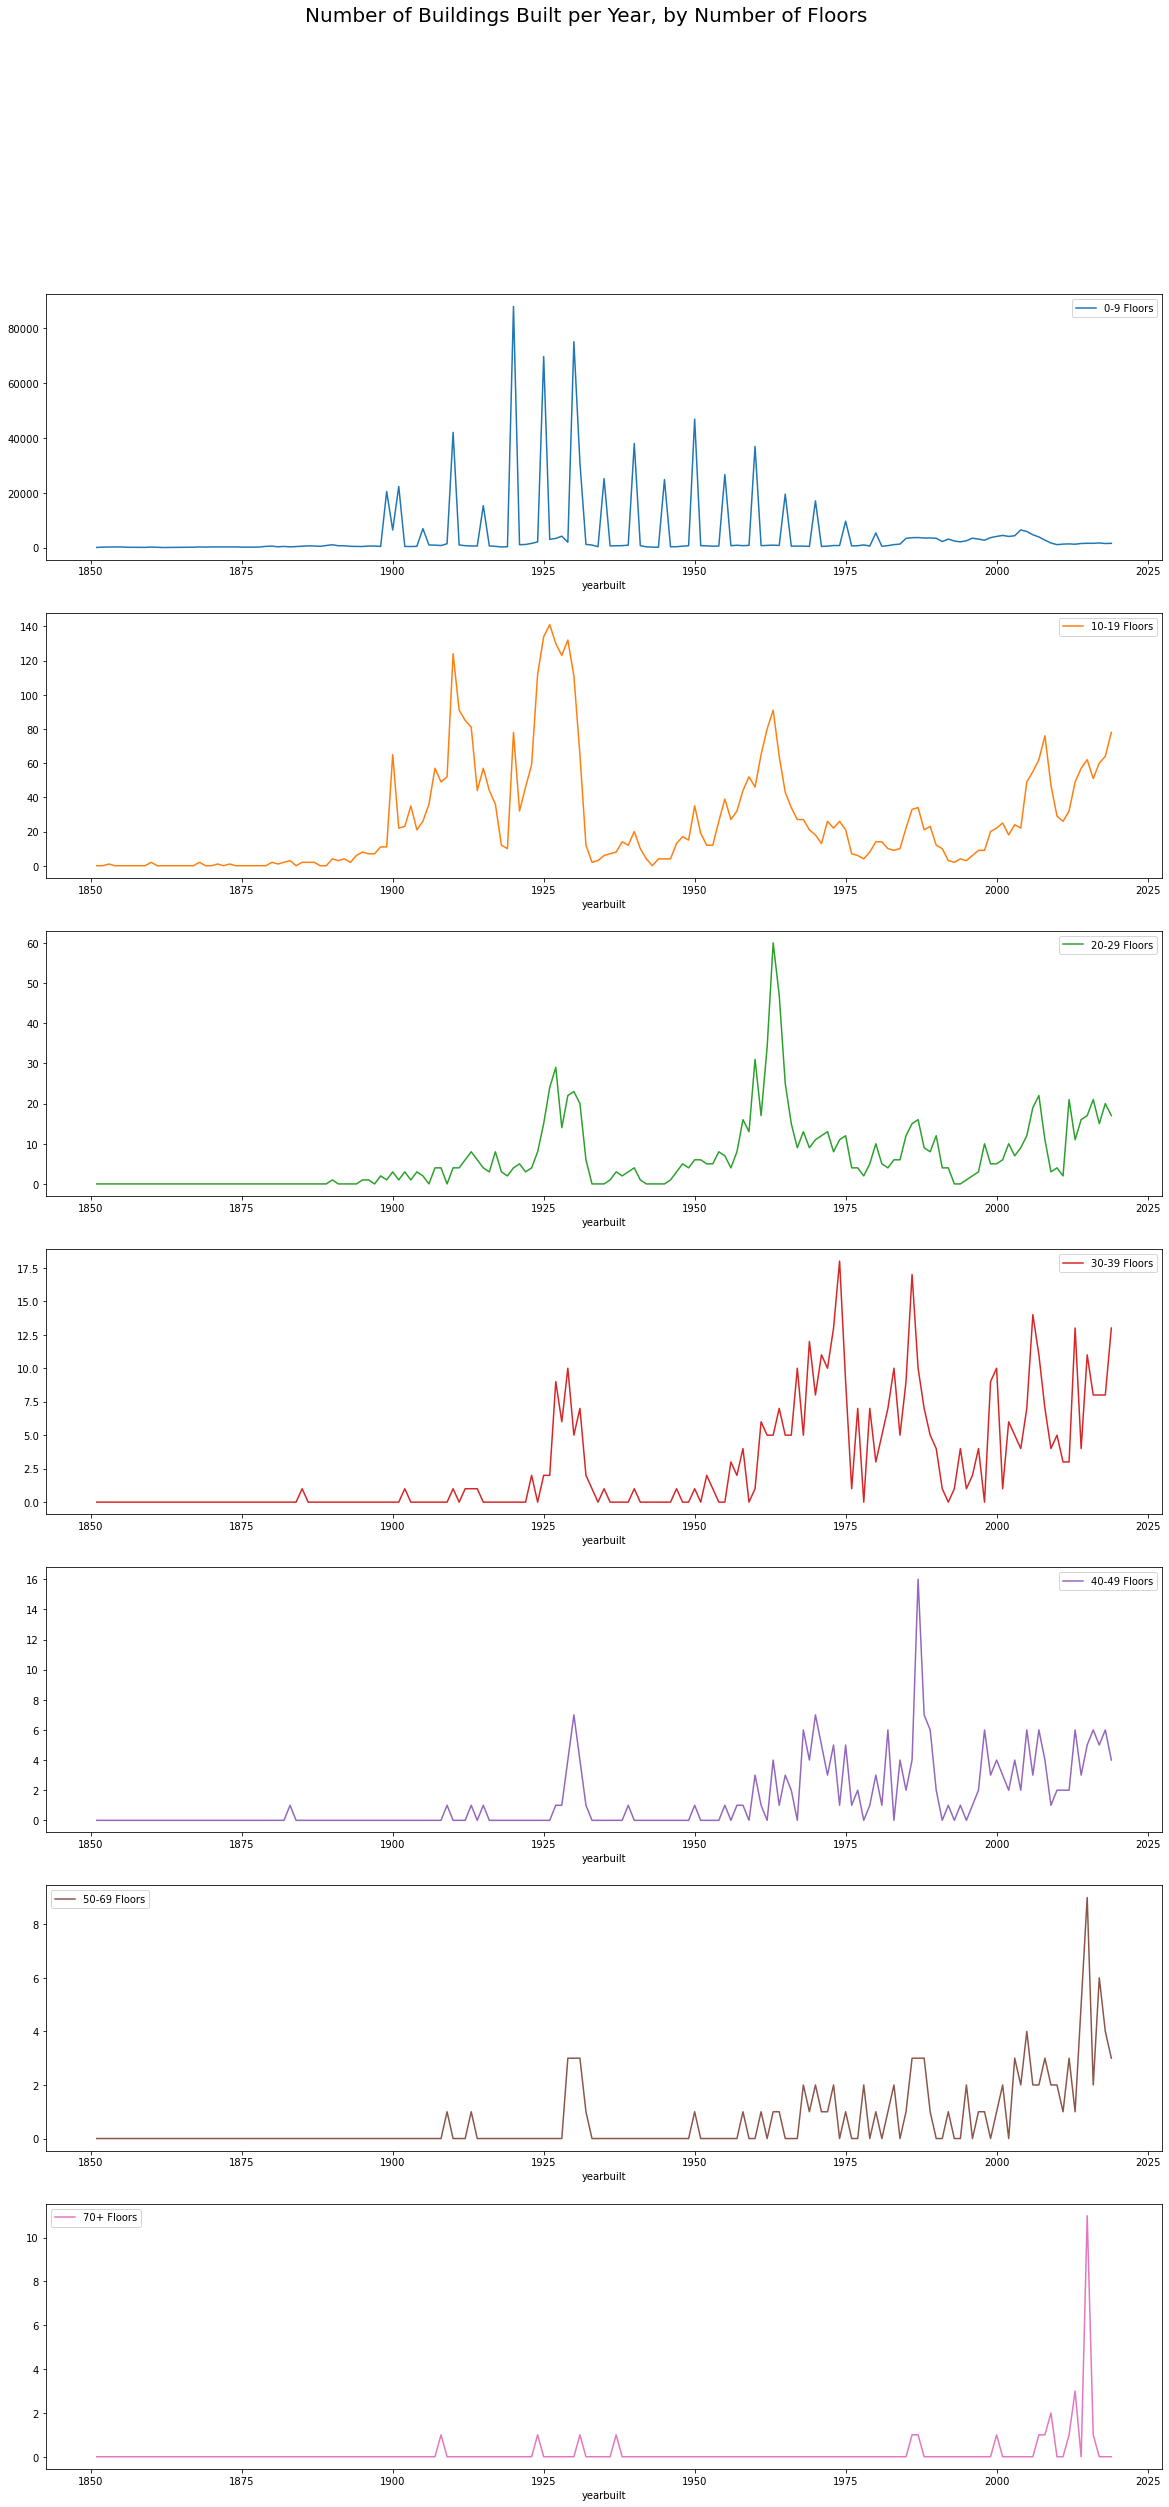

In [10]:
floors_years = ny[['numfloors','yearbuilt']]  #Seperate out the data we want
floors_years.reset_index(inplace = True, drop = True)  #Fix the index
floor_bins = [0,10,20,30,40,50,70,105]  #Define where we want the bins to occur
binlabs = ["0-9 Floors","10-19 Floors","20-29 Floors","30-39 Floors","40-49 Floors","50-69 Floors","70+ Floors"] #Some labels for the bins
byfloor = pd.cut(floors_years.numfloors, floor_bins, right = False, labels = binlabs) # Put things into bins by floors
floors_years = floors_years.join(byfloor, rsuffix = "bin", how = 'outer').groupby('numfloorsbin').yearbuilt.value_counts(sort = False) #Joins the bins on, groups by bin, and counts observations by year
floors_years = floors_years.unstack(level = 0, fill_value = 0) #Takes the grouped data and puts it in a dataframe with yearbuilt on rows and nd variables with valuecounts of floorbins by year for columns

#The magic of pyplot; can control lots of details
plt.rcParams['figure.figsize'] = [20,40]
plt.rcParams['figure.titlesize'] = 20 
plt.rcParams['axes.titlesize'] = 15

title = "Number of Buildings Built per Year, by Number of Floors" #The title
floors_years.plot(subplots = True, sharex = False, title = title) #plots with subplots
plt.show()

Above are plots of the number of buildings built each year by groupings of floors.  As we can see from the first plot, the data on shorter buildings is a bit more questionable.  

What's likely happening for building with 0-9 floors are modern catalogers looking at buildings which did not have a record (mostly 1-2 floor family homes) and assigning build date estimates to them, rounding to the nearest 5 year mark.  We can also see that short buildings constructed since the 80s have better records.  Most of the buildings built in NYC were between 0 and 9 floors, with a median height of 2 floors.

Amongst the higher buildings, we can see that the shorter amongst them are more common, and that taller buildings tend to be more recently constructed.

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [11]:
#This one isn't working
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['yearbuilt'], np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['numfloors'], np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

fig = go.FigureWidget(
    data = [
        go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['bbl'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
    ]
)

fig

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(247,252,245)'], [0.125,
                             'r…

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



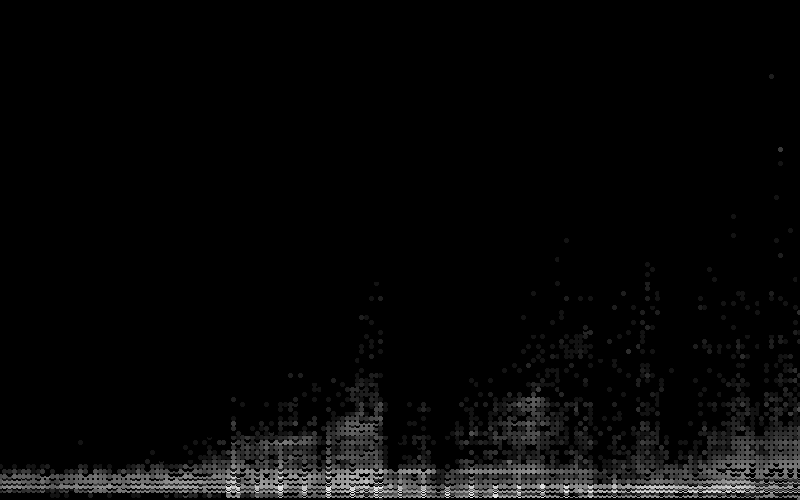

In [12]:
cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

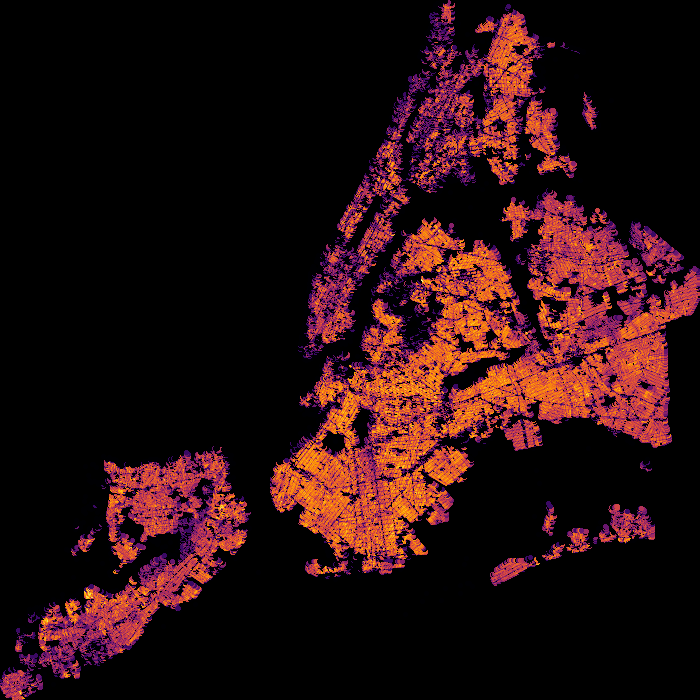

In [13]:
NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.




### Answer

For this, we want some value to represent 'land utilization'.  I'm going to estimate land utilization as 'building area'/'land value'.  My reasoning here is that 1: we have the data for that, and 2: building area can stand in as a representation of development on a property, which is then normalized by land value; land value will take into account the amount of land and it's relevant value.  Thus, this controls for how much land and the 'desirability' of the land.  The final unit of measurement we'll end up with is essentially the inverse of land-price per ft^2 building-space, which seems a good representation of land utilization.

In [14]:
#Let's get a few summary stats to get an idea of what these variable look like
print(ny.assessland.describe())
print(ny.bldgarea.describe())

#Segregate the data we want
dev_assess = ny[["assessland","bldgarea","xcoord","ycoord"]]

#Reset the index and drop observations with missing data
dev_assess.reset_index(inplace = True, drop = True)
dev_assess.dropna(inplace = True)

#Drop observations with land values of 0, which I don't believe, and will also throw up inf utilization values
dev_assess = dev_assess[dev_assess.assessland != 0]

#Make the land utilization stat
dev_assess["utilization"] = dev_assess.bldgarea/dev_assess.assessland

#quick data peek
print(dev_assess.head())
print(dev_assess.utilization.describe())



count    8.106760e+05
mean     1.101640e+05
std      4.076812e+06
min      0.000000e+00
25%      1.038000e+04
50%      1.416000e+04
75%      2.184000e+04
max      3.211276e+09
Name: assessland, dtype: float64
count    8.106750e+05
mean     6.706624e+03
std      6.024797e+04
min      0.000000e+00
25%      1.464000e+03
50%      2.072000e+03
75%      3.080000e+03
max      2.205181e+07
Name: bldgarea, dtype: float64
   assessland  bldgarea    xcoord    ycoord  utilization
0     24900.0    3360.0  996992.0  234157.0     0.134940
1     15960.0    2821.0  984030.0  159620.0     0.176754
2     12900.0    2508.0  982473.0  158966.0     0.194419
3      5460.0    1870.0  996091.0  164469.0     0.342491
4    229950.0    9000.0  997599.0  220113.0     0.039139
count    810452.000000
mean          0.164128
std           0.156689
min           0.000000
25%           0.092308
50%           0.130282
75%           0.190670
max          24.933333
Name: utilization, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



So now we have our land utilization factor.  As we might expect, it's a little right skewed; there are also some low land values which mess with things, but shouldn't be very visible.  Now let's plot it out.

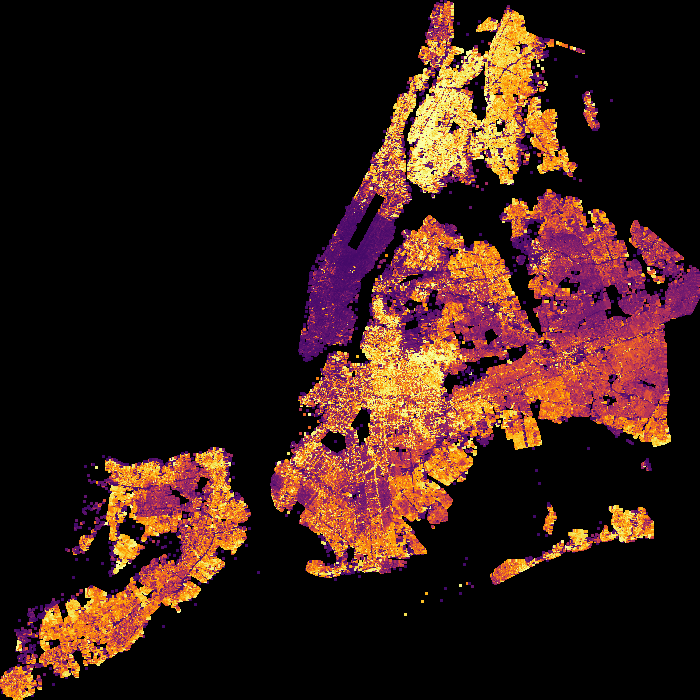

In [15]:
#Copied most of this from above, but tossed in the utilization term
NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(dev_assess, 'xcoord', 'ycoord', ds.mean("utilization"))
view = tf.shade(agg, cmap = cm(inferno,0.2), how='eq_hist')
export(tf.spread(view, px=1), 'firery')

Above we have a map of land utilization in terms of building floor space per land value.  The brighter areas have higher utilization, whereas darker areas have lower utilization.  From a developer's perspective one would be most interested in the darker areas, which are the places where buildings are smaller than one would expect given the value of the land they sit on. 

Interestingly enough, southern Manhattan is under-developed according to this figure.  I think what's happening here is that the 'utilization' term does not take into account the height of a building.  By my understanding, increasing a building's square-footage by building more floors gets more expensive the higher it gets; price to height is not linear.  The model above does not take that into account.  There probably is a formula for calculating cost/height, but it's probably location dependent, and I don't have it (This is where domain knowledge helps).

Let's try modifying our utilization term a bit.  This time, we'll gauge development as building-value/land-value, where higher values indicate more developed land.  This, like the previous term, should control for lot/building size, but might do a better job at capturing the actual value of the building.  

One note though: the data set does not directly contain building values, but contains total value.  We'll assume that the total value is mostly composed of the building value and land value (and nothing else significant); by subtracting the land value from the total value, we should then arrive at a building value.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



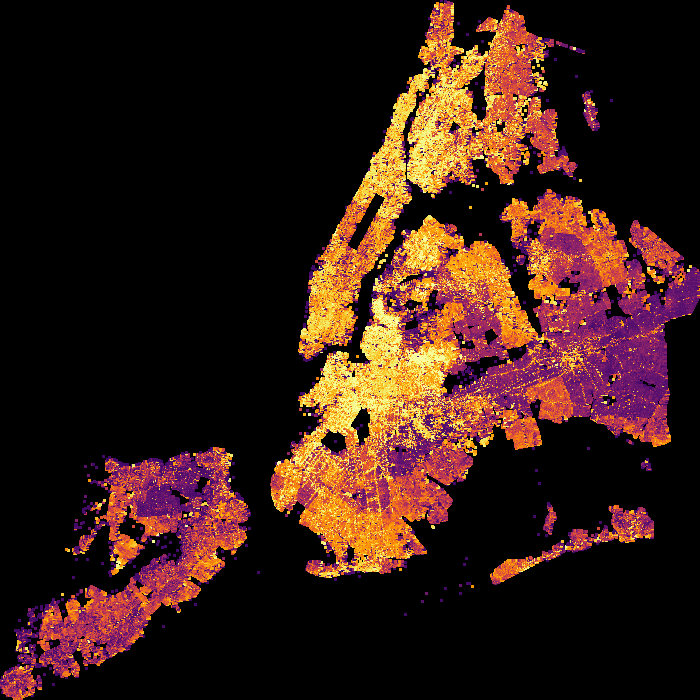

In [16]:
#Copy-pasted most this stuff again from above because I can't be bothered
dev_assess = ny[["assessland","assesstot","xcoord","ycoord"]]
dev_assess.reset_index(inplace = True, drop = True)
dev_assess.dropna(inplace = True)
dev_assess = dev_assess[dev_assess.assessland != 0]
dev_assess["utilization"] = (dev_assess.assesstot-dev_assess.assessland)/dev_assess.assessland #Changed the formula

NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(dev_assess, 'xcoord', 'ycoord', ds.mean("utilization"))
view = tf.shade(agg, cmap = cm(inferno,0.2), how='eq_hist')
export(tf.spread(view, px=1), 'firery')

Now the picture looks much different.  Brighter areas are again considered more developed.  Here, it's south-east Queens and Staten Island that are under-developed as gauged by the value of their buildings compared to the value of the land on which they sit. 

If one were to take input from both figures, I think one would settle on parts of Queens having the most potential for development.